Food Classification

In [15]:
!nvidia-smi

Sun Dec 15 19:10:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              1W /   40W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch

print(torch.cuda.is_available())

True


In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryDirectory
import time
from tqdm import tqdm

cudnn.benchmark = True

Transfer learning method

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(24, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [3]:
class Food101(Dataset):
    def __init__(self, root: str, split: str, transforms = None):
        self.data = []
        self.to_class = {}
        self.to_index = {}

        self.root = root
        self.split = split
        self.transform = transforms

        # Validate root directory
        if not os.path.isdir(self.root):
            raise ValueError(f"Root directory not found: {self.root}")

        # load data
        file_data = os.path.join(self.root, f"meta/{self.split}.txt")
        with open(file_data, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            self.data = [line.strip() for line in lines]

        # create map class
        class_file = os.path.join(self.root, f"meta/classes.txt")
        with open(class_file, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            self.to_index = {line.split('\n')[0].strip(): index for index, line in enumerate(lines)}
            self.to_class = {v: k for k, v in self.to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, f"images/{self.data[index]}.jpg")
        image = Image.open(image_path).convert('RGB')

        label_name = self.data[index].split('/')[0]
        label = self.to_index[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [5]:
root_data = "food-101"
train_dataset = Food101(root=root_data, split='train', transforms=train_transform)
val_dataset = Food101(root=root_data, split='test', transforms=test_transform)

train_set = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_set = DataLoader(val_dataset, batch_size=16, shuffle=False)

Show images in each batch

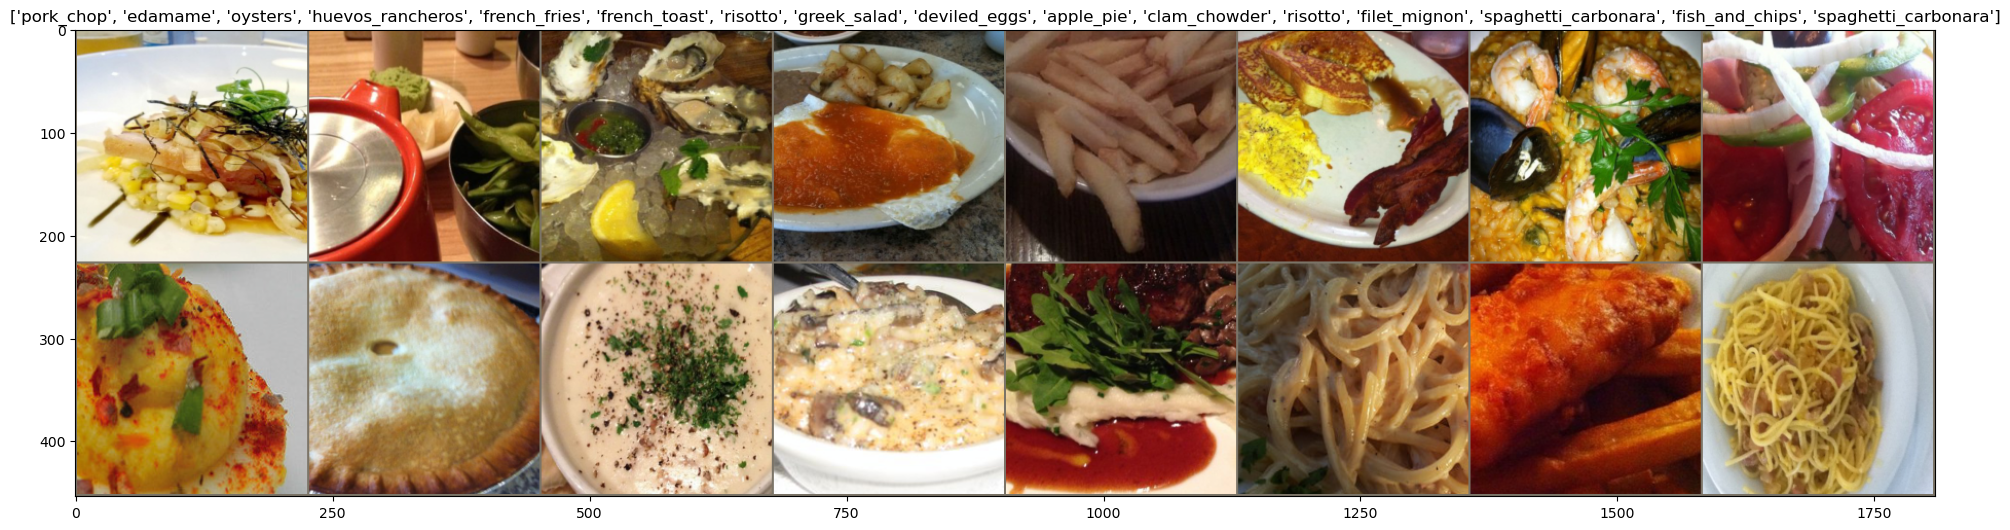

In [7]:
inputs, classes = next(iter(train_set))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_dataset.to_class[x.item()] for x in classes])

In [8]:
print(f"Number of classes: {len(train_dataset.to_class)}")
len_class = len(train_dataset.to_class)

Number of classes: 101


Test Mobilenet V2

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.eval()  

image_path = "./image/pizza.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0) 

with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = F.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

with open('labels.txt', mode='r') as f:
    lines = f.readlines()

print(f"It is {lines[predicted_class]}")

It is pizza



In [70]:
model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_features = model_ft.classifier[1].in_features

model_ft.classifier = nn.Sequential(
    nn.Linear(num_features, 128), 
    nn.ReLU(),                
    nn.Linear(128, 128),       
    nn.ReLU(),
    nn.Linear(128, len_class),
)

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

print(device)

cuda:0


In [72]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [76]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    since = time.time()

    # Lists to store loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                data_loader = train_loader if phase == 'train' else val_loader

                # Use tqdm to wrap the data loader for progress bar
                with tqdm(data_loader, unit='batch') as t:
                    for inputs, labels in t:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        optimizer.zero_grad()
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                        # Update tqdm description for loss and accuracy
                        t.set_postfix(loss=running_loss / (inputs.size(0) * (t.n + 1)),
                                      acc=running_corrects.double() / (inputs.size(0) * (t.n + 1)))

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Store the loss and accuracy for plotting
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    # After training, plot the training and validation loss and accuracy
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

    return model

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [77]:
trained_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, train_set, val_set, num_epochs=25, device=device)

Epoch 0/24
----------


 69%|██████▉   | 3282/4735 [50:16<22:15,  1.09batch/s, acc=tensor(0.0523, device='cuda:0', dtype=torch.float64), loss=4.41]     


KeyboardInterrupt: 

I want to switch to n-shot learning because:

1 It doesn’t need re-training, which saves time.

2 It uses small datasets, so training is faster.

But now I want to make small data and use transfer learning

first I want to modify Food101 class to make it can specific type of food and size of it

In [5]:
class Food101(Dataset):
    def __init__(self, root: str, split: str, foods: list, size: int, transforms = None):
        self.data = []
        self.foods = foods
        self.size = size
        self.to_class = {}
        self.to_index = {}

        self.root = root
        self.split = split
        self.transform = transforms

        # Validate root directory
        if not os.path.isdir(self.root):
            raise ValueError(f"Root directory not found: {self.root}")

        # load data
        file_data = os.path.join(self.root, f"meta/{self.split}.txt")
        food_count = {food:0 for food in foods}
        with open(file_data, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                food = line.split('/')[0].strip()
                if food in self.foods and food_count[food] < size: 
                    self.data.append(line.strip())
                    food_count[food] += 1

        # create map class
        class_file = os.path.join(self.root, f"meta/classes.txt")
        with open(class_file, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            self.to_index = {line.split('\n')[0].strip(): index for index, line in enumerate(lines)}
            self.to_class = {v: k for k, v in self.to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, f"images/{self.data[index]}.jpg")
        image = Image.open(image_path).convert('RGB')

        label_name = self.data[index].split('/')[0]
        label = self.to_index[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
root_data = "food-101"
foods = ["pad_thai", "gyoza"]
train_dataset = Food101(root=root_data, split='train', foods=foods, size=120, transforms=train_transform)
val_dataset = Food101(root=root_data, split='test', foods=foods, size=30, transforms=test_transform)

train_set = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_set = DataLoader(val_dataset, batch_size=64, shuffle=False)

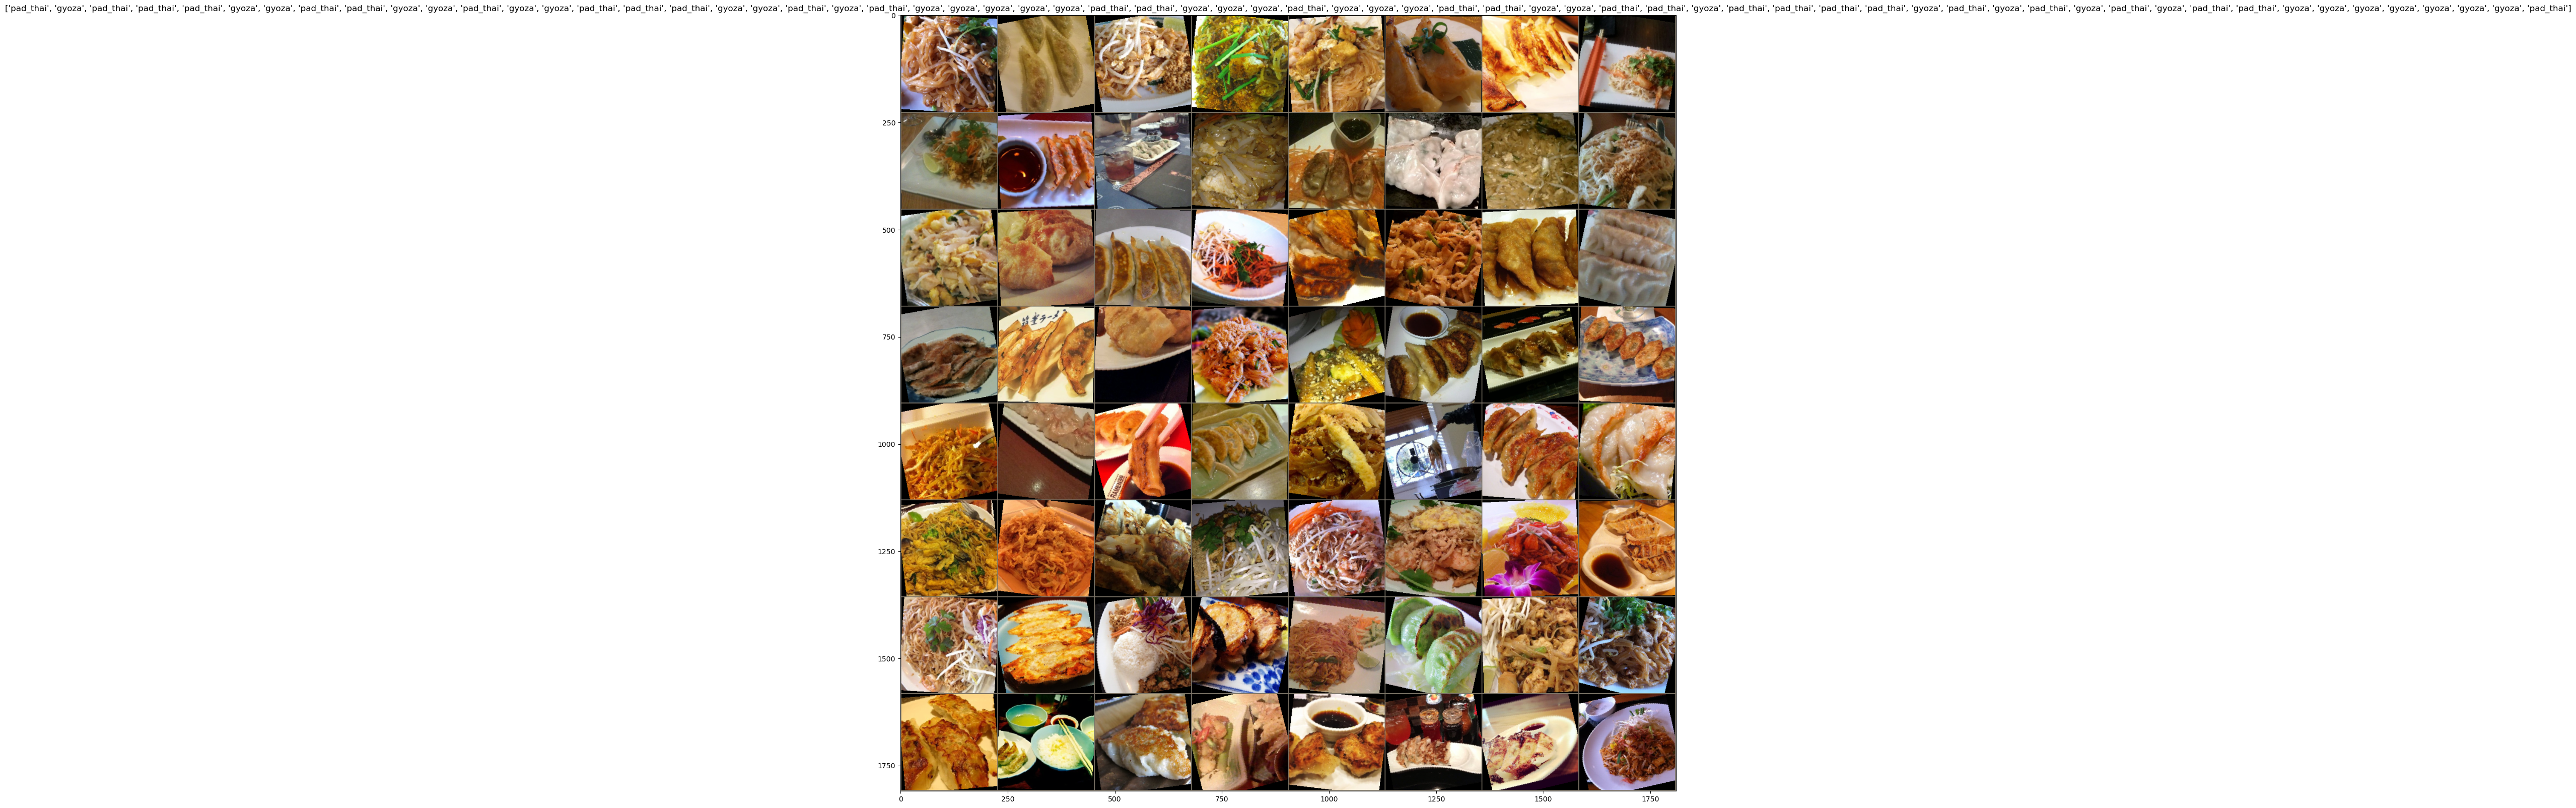

In [8]:
inputs, classes = next(iter(train_set))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_dataset.to_class[x.item()] for x in classes])

In [9]:
for food in foods:print(f"{food} -> label: {train_dataset.to_index[food]}")

pad_thai -> label: 70
gyoza -> label: 52


In [33]:
model = models.resnet18(pretrained=True)

c:\Users\Auto\anaconda3\envs\Food\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Auto\anaconda3\envs\Food\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
def get_fc_layers(fc_sizes, ps):
    fc_layers_list = []
    for fc_size,p in zip(fc_sizes, ps):
        fc_layers_list.append(nn.Linear(fc_size[0], fc_size[1]))
        fc_layers_list.append(nn.ReLU(inplace=True))
        fc_layers_list.append(nn.BatchNorm1d(fc_size[1]))
        fc_layers_list.append(nn.Dropout(p=p))
    return nn.Sequential(*fc_layers_list)

In [34]:
n_class=1
model.fc = nn.Sequential(get_fc_layers(fc_sizes=[(512,300),(300,100)],ps=[0.5,0.5]),
              nn.Linear(100,n_class))

Freeze weight (Body)

In [35]:
for module in list(model.children())[:-1]:
  for param in module.parameters(): param.requires_grad = False

In [36]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-2)
epoch = 3

model = model.cuda()
losses_train_epoch, losses_valid_epoch, accs_valid_epoch = [], [], []
for i in range(epoch):
    print(f'epoch {i+1}')

    # training
    losses_train_batch = []
    model.train()
    for xb, yb in train_set:
        xb, yb = xb.cuda(), yb.cuda()
        target = (yb == 70).float()
        pred = model(xb).reshape(-1)
        loss = loss_function(pred, target)

        loss.backward()
        losses_train_batch.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    losses_train_epoch.append(np.mean(losses_train_batch))
    print(f'train loss: {losses_train_epoch[-1]}')

    # validation
    losses_valid_batch = []
    accs_valid_batch = []
    model.eval()

    with torch.no_grad():
        for xb, yb in val_set:
            xb, yb = xb.cuda(), yb.cuda()
            target = (yb == 70).float()

            pred = model(xb).reshape(-1)
            loss = loss_function(pred, target)
            losses_valid_batch.append(loss.item())

            y_pred = (torch.sigmoid(pred).cpu().numpy() > 0.5).astype(int)
            acc = (y_pred == target.cpu().numpy()).mean()
            accs_valid_batch.append(acc)

    losses_valid_epoch.append(np.mean(losses_valid_batch))
    accs_valid_epoch.append(np.mean(accs_valid_batch))

    print(f"Validation Loss: {losses_valid_epoch[-1]}")
    print(f"Validation Accuracy: {accs_valid_epoch[-1]}")

epoch 1
train loss: 0.6730435788631439
Validation Loss: 0.639248788356781
Validation Accuracy: 0.8666666666666667
epoch 2
train loss: 0.5738277435302734
Validation Loss: 0.5923383831977844
Validation Accuracy: 0.9333333333333333
epoch 3
train loss: 0.5394040942192078
Validation Loss: 0.5297225117683411
Validation Accuracy: 0.95


Unfreeze

In [37]:
for module in list(model.children())[:-1]:
  for param in module.parameters(): param.requires_grad = True

In [38]:
torch.save(model.state_dict(),'model/model_unfreeze_3.pt')

Find good learning rate

In [39]:
class CancelTrainException(Exception): pass

class LRFinder:

    def __init__(self, model, data_loader, loss_func, opt, lr_range, max_iter):
        self.lrs = []
        self.losses = []
        self.model = model
        self.data_loader = data_loader
        self.loss_func = loss_func
        self.opt = opt
        self.lr_range = lr_range
        self.max_iter = max_iter

    def run(self):
        best_loss = 1e9
        i=0
        while i<self.max_iter:
          print(f"I: {i}")
          for xb, yb in self.data_loader:

            # move to cuda
            xb, yb = xb.cuda(), yb.cuda()
            target = (yb == 70).float()
            pred = model(xb).reshape(-1)

            # begin batch
            pos = i/self.max_iter
            i+=1
            lr = self.lr_range[0]*(self.lr_range[1]/self.lr_range[0])**pos
            for pg in self.opt.param_groups: pg['lr'] = lr

            loss = self.loss_func(pred, target)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

            # after step
            if (loss.item() > best_loss*10) or (i==self.max_iter): raise CancelTrainException()
            if loss.item() < best_loss: best_loss = loss.item()

            # after batch
            self.lrs.append(lr)
            self.losses.append(loss.item())

    def plot_lr(self):
        # plot lr x loss
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [40]:
lr_finder = LRFinder(model = model, 
                     data_loader = train_set, 
                     loss_func = nn.BCEWithLogitsLoss(), 
                     opt = optim.SGD(model.parameters(),lr=1e-2), 
                     lr_range = [1e-6,1],
                     max_iter = 100)

In [41]:
lr_finder.run()

I: 0
I: 4
I: 8
I: 12
I: 16
I: 20
I: 24
I: 28
I: 32
I: 36
I: 40
I: 44
I: 48
I: 52
I: 56
I: 60
I: 64
I: 68
I: 72
I: 76
I: 80
I: 84
I: 88


CancelTrainException: 

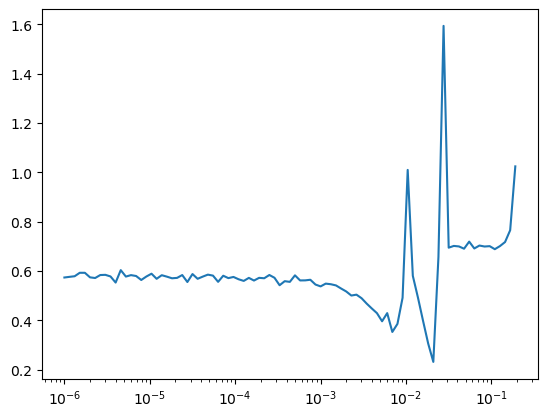

In [42]:
lr_finder.plot_lr()

Continue training using unfreeze model and best learing rate

In [43]:
model.load_state_dict(torch.load('model/model_unfreeze_3.pt'))

C:\Users\Auto\AppData\Local\Temp\ipykernel_16808\1049419021.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_unfreeze_3.pt'))


<All keys matched successfully>

In [44]:
class LRSlicer:
    def __init__(self, lr_range, total_steps):
        self.lr_range = lr_range
        self.total_steps = total_steps
        self.step = (lr_range[1]/lr_range[0])**(1/(total_steps-1))
    def __call__(self,pos):
        assert pos < self.total_steps
        if pos==self.total_steps-1: return self.lr_range[1]
        return self.lr_range[0]*self.step**pos

In [45]:
lr_slicer = LRSlicer([3e-4,3e-3],4)
for i in range(4): print(f'learning rate {i}:{lr_slicer(i)}')

learning rate 0:0.0003
learning rate 1:0.0006463304070095651
learning rate 2:0.0013924766500838337
learning rate 3:0.003


In [46]:
optimizer = optim.SGD([
    {'params':model.conv1.parameters(), 'lr':lr_slicer(0)},
    {'params':model.bn1.parameters(), 'lr':lr_slicer(0)},
    {'params':model.layer1.parameters(), 'lr':lr_slicer(0)},
    {'params':model.layer2.parameters(), 'lr':lr_slicer(1)},
    {'params':model.layer3.parameters(), 'lr':lr_slicer(2)},
    {'params':model.layer4.parameters(), 'lr':lr_slicer(3)},
    {'params':model.fc.parameters(), 'lr':lr_slicer(3)},
])

In [47]:
loss_function = nn.BCEWithLogitsLoss()
epoch = 8

model = model.cuda()
losses_train_epoch, losses_valid_epoch, accs_valid_epoch = [], [], []
for i in range(epoch):
    print(f'epoch {i+1}')

    # training
    losses_train_batch = []
    model.train()
    for xb, yb in train_set:
        xb, yb = xb.cuda(), yb.cuda()
        target = (yb == 70).float()
        pred = model(xb).reshape(-1)
        loss = loss_function(pred, target)

        loss.backward()
        losses_train_batch.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    losses_train_epoch.append(np.mean(losses_train_batch))
    print(f'train loss: {losses_train_epoch[-1]}')

    # validation
    losses_valid_batch = []
    accs_valid_batch = []
    model.eval()

    with torch.no_grad():
        for xb, yb in val_set:
            xb, yb = xb.cuda(), yb.cuda()
            target = (yb == 70).float()

            pred = model(xb).reshape(-1)
            loss = loss_function(pred, target)
            losses_valid_batch.append(loss.item())

            y_pred = (torch.sigmoid(pred).cpu().numpy() > 0.5).astype(int)
            acc = (y_pred == target.cpu().numpy()).mean()
            accs_valid_batch.append(acc)

    losses_valid_epoch.append(np.mean(losses_valid_batch))
    accs_valid_epoch.append(np.mean(accs_valid_batch))

    print(f"Validation Loss: {losses_valid_epoch[-1]}")
    print(f"Validation Accuracy: {accs_valid_epoch[-1]}")

epoch 1
train loss: 0.4800381287932396
Validation Loss: 0.49142539501190186
Validation Accuracy: 0.9333333333333333
epoch 2
train loss: 0.4668726325035095
Validation Loss: 0.45639532804489136
Validation Accuracy: 0.9666666666666667
epoch 3
train loss: 0.46126560121774673
Validation Loss: 0.3963784873485565
Validation Accuracy: 0.9833333333333333
epoch 4
train loss: 0.4649796858429909
Validation Loss: 0.3597618341445923
Validation Accuracy: 0.9833333333333333
epoch 5
train loss: 0.42237749695777893
Validation Loss: 0.332221120595932
Validation Accuracy: 0.9666666666666667
epoch 6
train loss: 0.4231579750776291
Validation Loss: 0.3154418170452118
Validation Accuracy: 0.95
epoch 7
train loss: 0.42991748452186584
Validation Loss: 0.2893112599849701
Validation Accuracy: 0.9666666666666667
epoch 8
train loss: 0.3681439682841301
Validation Loss: 0.2584766447544098
Validation Accuracy: 0.95


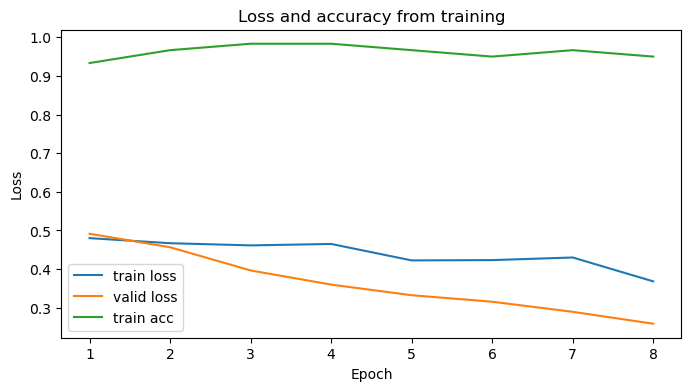

In [56]:
line = np.arange(1, 9)

plt.figure(figsize=(8, 4))
plt.title("Loss and accuracy from training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(line, losses_train_epoch, label="train loss")
plt.plot(line, losses_valid_epoch, label="valid loss")
plt.plot(line, accs_valid_epoch, label="train acc")
plt.legend()
plt.show()

Confusion Metric

In [80]:
model.eval()
preds=[]
trues=[]
for xb, yb in val_set:
  preds.append((torch.sigmoid(model(xb.cuda())).cpu().detach().numpy() > 0.5).astype(int))
  trues.append(yb.numpy().astype(int))

preds = np.concatenate(preds).reshape(-1)
trues = np.concatenate(trues).reshape(-1)
trues = (trues == 70).astype(int)

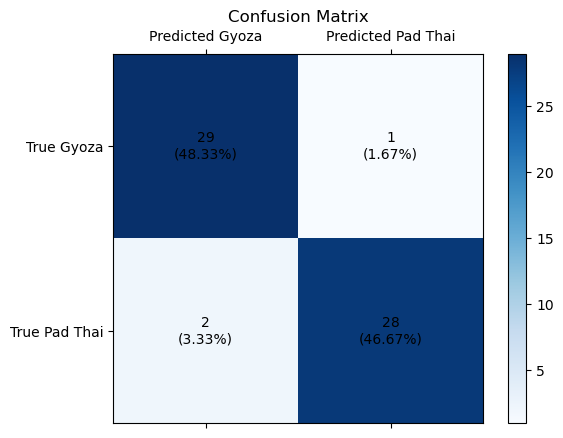

In [85]:
TP = np.sum((trues == 1) & (preds == 1))  # True positives
TN = np.sum((trues == 0) & (preds == 0))  # True negatives
FP = np.sum((trues == 0) & (preds == 1))  # False positives
FN = np.sum((trues == 1) & (preds == 0))  # False negatives
conf_matrix = np.array([[TN, FP], [FN, TP]])

fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Blues')

fig.colorbar(cax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Predicted Gyoza', 'Predicted Pad Thai'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['True Gyoza', 'True Pad Thai'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix) * 100:.2f}%)', 
                ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.show()

In [87]:
def accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    return correct / len(true_labels)

acc = accuracy(trues, preds)
print(f"Accuracy: {acc}")

Accuracy: 0.95


In [88]:
torch.save(model.state_dict(),'model/model_best_1.pt')

Testing image

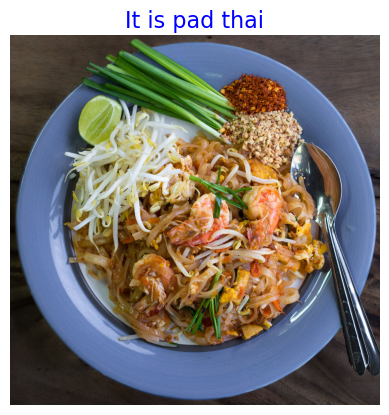

In [117]:
image = Image.open('image/pad_thai.jpg').convert('RGB')
original_image = image.copy() 
image = test_transform(image)
image = image.unsqueeze(0)

to_class = {0:"gyoza", 1:"pad thai"}
with torch.no_grad():
    transformed_image = image.to('cuda:0')
    output = model(transformed_image)
    label = (torch.sigmoid(output).cpu().detach().numpy() > 0.5).astype(int).reshape(-1)[0]

plt.imshow(original_image)
plt.axis('off')
plt.title(f"It is {to_class[label]}", fontsize=16, color='blue')
plt.show()